# Accessing cloud satellite data

- Funding: Interagency Implementation and Advanced Concepts Team [IMPACT](https://earthdata.nasa.gov/esds/impact) for the Earth Science Data Systems (ESDS) program and AWS Public Dataset Program
  
### Credits: Tutorial development
* [Dr. Chelle Gentemann](mailto:gentemann@faralloninstitute.org) -  [Twitter](https://twitter.com/ChelleGentemann)   - Farallon Institute

### Satellite data

Satellite data come from either polar or low inclination orbits that circle the Earth or geostationary orbits that hold a location above a specific location on the Earth, near the Equator.  The type of data from satellites depends on both the orbit and the type of instrument.  There are definitions for the different satellite data types.
- L1 - satellite observations, usually each observation has a lat/lon/time associated with it
- L2 - derived geophysical retrievals (eg. SST), still with lat/lon/time
- L3 - variables mapped to a uniform space/time grid
- L4 - model output or analysis of data, may include multiple sensors

There are several different formats that satellite data:  [netCDF](https://www.unidata.ucar.edu/software/netcdf/), [HDF5](https://www.hdfgroup.org/solutions/hdf5/), and [geoTIFF](https://earthdata.nasa.gov/esdis/eso/standards-and-references/geotiff).
There are also som newer cloud optimized formats that data: [Zarr](https://zarr.readthedocs.io/en/stable/), Cloud Optimized GeoTIFF ([COG](https://www.cogeo.org/)).

### Understand the data
Data access can be easy and fast on the cloud, but to avoid potential issues down the road, spend time to understand the strengths and weaknesses of any data.  Any science results will need to address uncertainties in the data, so it is easier to spend time at the beginning to understand them and avoid data mis-application.

#### This tutorial will focus on netCDF/HDF5/Zarr

### Data proximate computing
These are BIG datasets that you can analyze on the cloud without downloading the data.  
You can run this on your phone, a Raspberry Pi, laptop, or desktop.   
By using public cloud data, your science is reproducible and easily shared!

The OHW Jupyter Hub is a m5.2xlarge instance shared by up to 4 users.  What does that mean?  [m5.2xlarge](https://aws.amazon.com/ec2/instance-types/m5/) has 8 vCPU and 32 GB memory.
If there are 3 other users on your node, then the memory could be used up fast by large satellite datasets, so just be a little aware of that when you want to run something....

### Here we will demonstrate some ways to access the different SST datasets on AWS:
- AWS MUR sea surface temperatures  (L4)
- AWS GOES sea surface temperatures  (L2)
- AWS Himawari sea surface temperatures (L2 and L3)
- ERA5 data (L4)

### To run this notebook

Code is in the cells that have <span style="color: blue;">In [  ]:</span> to the left of the cell and have a colored background

To run the code:
- option 1) click anywhere in the cell, then hold `shift` down and press `Enter`
- option 2) click on the Run button at the top of the page in the dashboard

Remember:
- to insert a new cell below press `Esc` then `b`
- to delete a cell press `Esc` then `dd`

### First start by importing libraries


# How to find an AWS Public Dataset

- Click here: [AWS Public Dataset](https://aws.amazon.com/opendata/)




-------------------------------------------------------





- Click on `Find public available data on AWS` button
- Search for MUR
- Select [MUR SST](https://registry.opendata.aws/mur/)

 
 
 
 

-------------------------------------------------------

![](./awsmur.png)










## [MUR SST](https://podaac.jpl.nasa.gov/Multi-scale_Ultra-high_Resolution_MUR-SST) [AWS Public dataset program](https://registry.opendata.aws/mur/) 

### Access the MUR SST Zarr store which is in an s3 bucket.  

![image](https://podaac.jpl.nasa.gov/Podaac/thumbnails/MUR-JPL-L4-GLOB-v4.1.jpg)

We will start with my favorite Analysis Ready Data (ARD) format: [Zarr](https://zarr.readthedocs.io/en/stable/).  Using data stored in Zarr is fast, simple, and contains all the metadata normally in a netcdf file, so you can figure out easily what is in the datastore.  

- Fast - Zarr is fast because all the metadata is consolidated into a .json file.  Reading in massive datasets is lightning fast because it only reads the metadata and does read in data until it needs it for compute.

- Simple - Filenames?  Who needs them? Who cares?  Not I.  Simply point your read routine to the data directory.

- Metadata - all you want!

In [1]:
# filter some warning messages
import warnings 
warnings.filterwarnings("ignore") 

#libraries
import datetime as dt
import xarray as xr
import fsspec
import s3fs
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
# make datasets display nicely
xr.set_options(display_style="html")  

#magic fncts #put static images of your plot embedded in the notebook
%matplotlib inline  
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 


[fsspec.get_mapper](https://filesystem-spec.readthedocs.io/en/latest/api.html?highlight=get_mapper#fsspec.get_mapper) Creates a mapping between your computer and the s3 bucket.  This isn't necessary if the Zarr file is stored locally.

[xr.open_zarr](http://xarray.pydata.org/en/stable/generated/xarray.open_zarr.html) Reads a Zarr store into an Xarray dataset


In [2]:
%%time
file_location = 's3://mur-sst/zarr'

ikey = fsspec.get_mapper(file_location, anon=True)

ds_sst = xr.open_zarr(ikey,consolidated=True)

ds_sst

CPU times: user 2.79 s, sys: 55.2 ms, total: 2.85 s
Wall time: 3.44 s


,Array,Chunk
Bytes,16.70 TB,257.72 MB
Shape,"(6443, 17999, 36000)","(6443, 100, 100)"
Count,64801 Tasks,64800 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,16.70 TB,257.72 MB
Shape,"(6443, 17999, 36000)","(6443, 100, 100)"
Count,64801 Tasks,64800 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


### Read entire 10 years of data at 1 point.

Select the ``analysed_sst`` variable over a specific time period, `lat`, and `lon` and load the data into memory.  This is small enough to load into memory which will make calculating climatologies easier in the next step.

CPU times: user 386 ms, sys: 256 ms, total: 641 ms
Wall time: 3.69 s


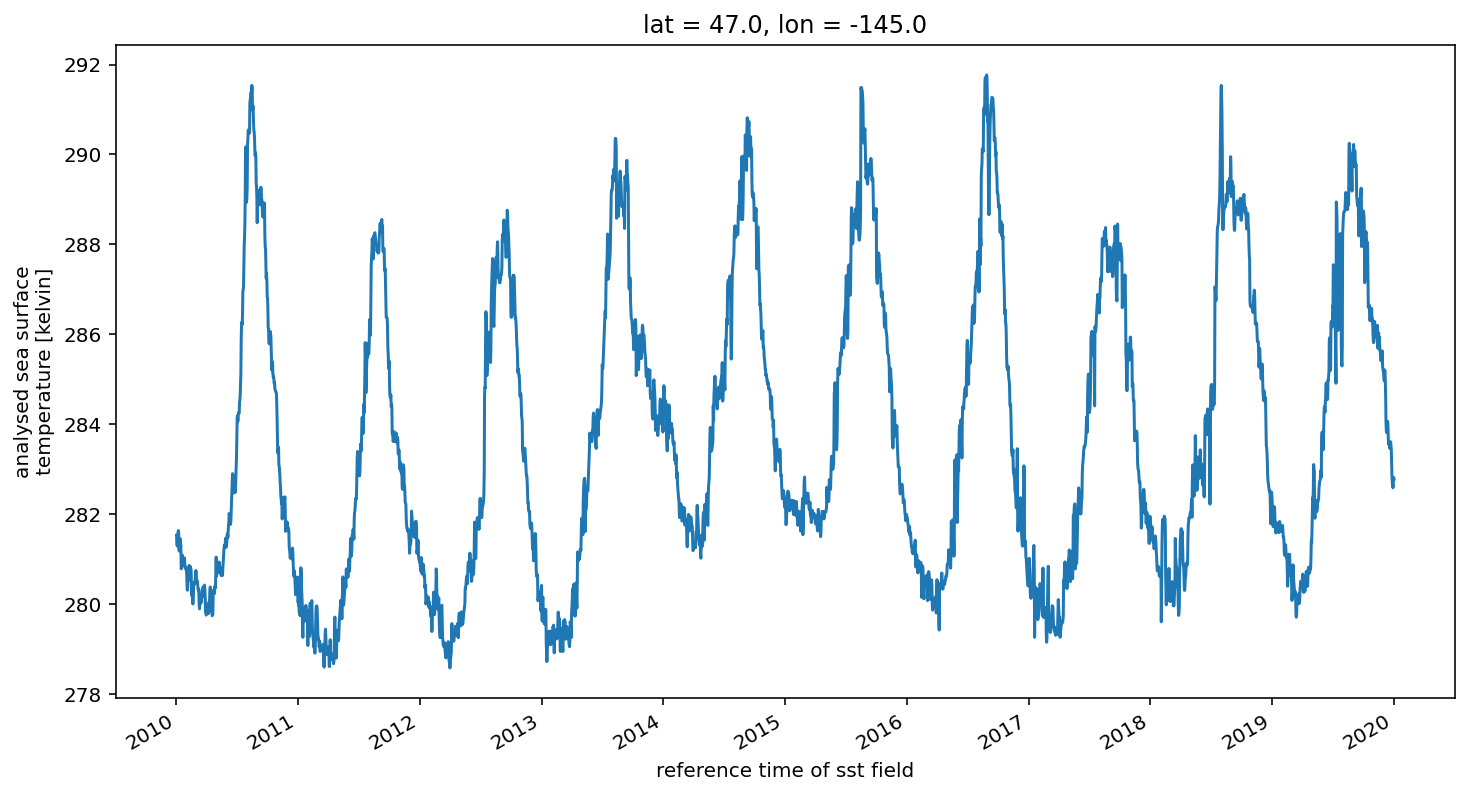

In [3]:
%%time

sst_timeseries = ds_sst['analysed_sst'].sel(time = slice('2010-01-01','2020-01-01'),
                                            lat  = 47,
                                            lon  = -145
                                           ).load()

sst_timeseries.plot()

### The anomaly is more interesting...  

Use [.groupby](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.groupby.html#xarray-dataarray-groupby) method to calculate the climatology and [.resample](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.resample.html#xarray-dataset-resample) method to then average it into 1-month bins.
- [DataArray.mean](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.mean.html#xarray-dataarray-mean) arguments are important! Xarray uses metadata to plot, so keep_attrs is a nice feature.  Also, for SST there are regions with changing sea ice.  Setting skipna = False removes these regions. 

CPU times: user 409 ms, sys: 528 µs, total: 409 ms
Wall time: 408 ms


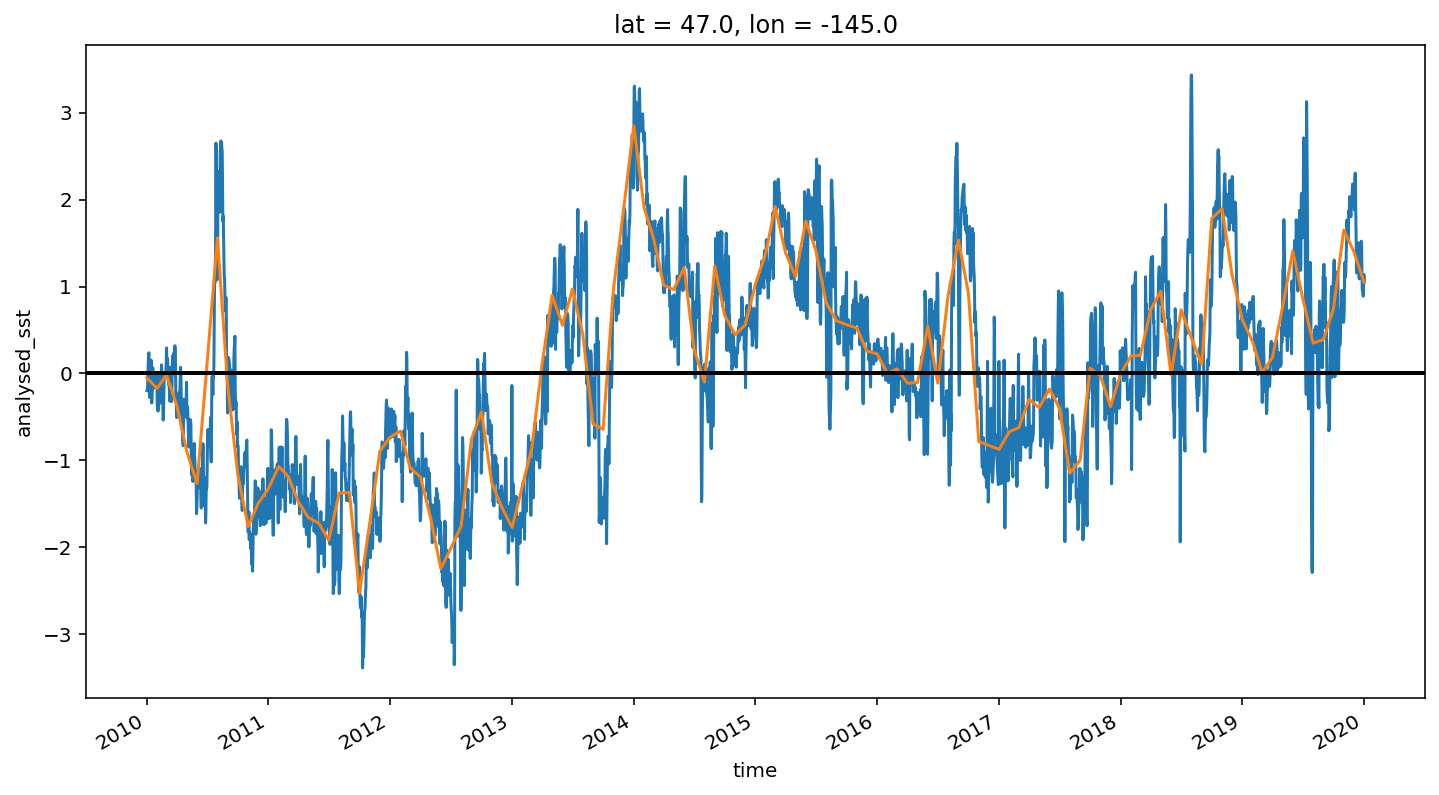

In [4]:
%%time

sst_climatology = sst_timeseries.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=False)

sst_anomaly = sst_timeseries.groupby('time.dayofyear')-sst_climatology

sst_anomaly_monthly = sst_anomaly.resample(time='1MS').mean(keep_attrs=True,skipna=False)

#plot the data
sst_anomaly.plot()
sst_anomaly_monthly.plot()
plt.axhline(linewidth=2,color='k')

# Chukchi Sea SST timeseries

# Note SST is set to -1.8 C (271.35 K) when ice is present

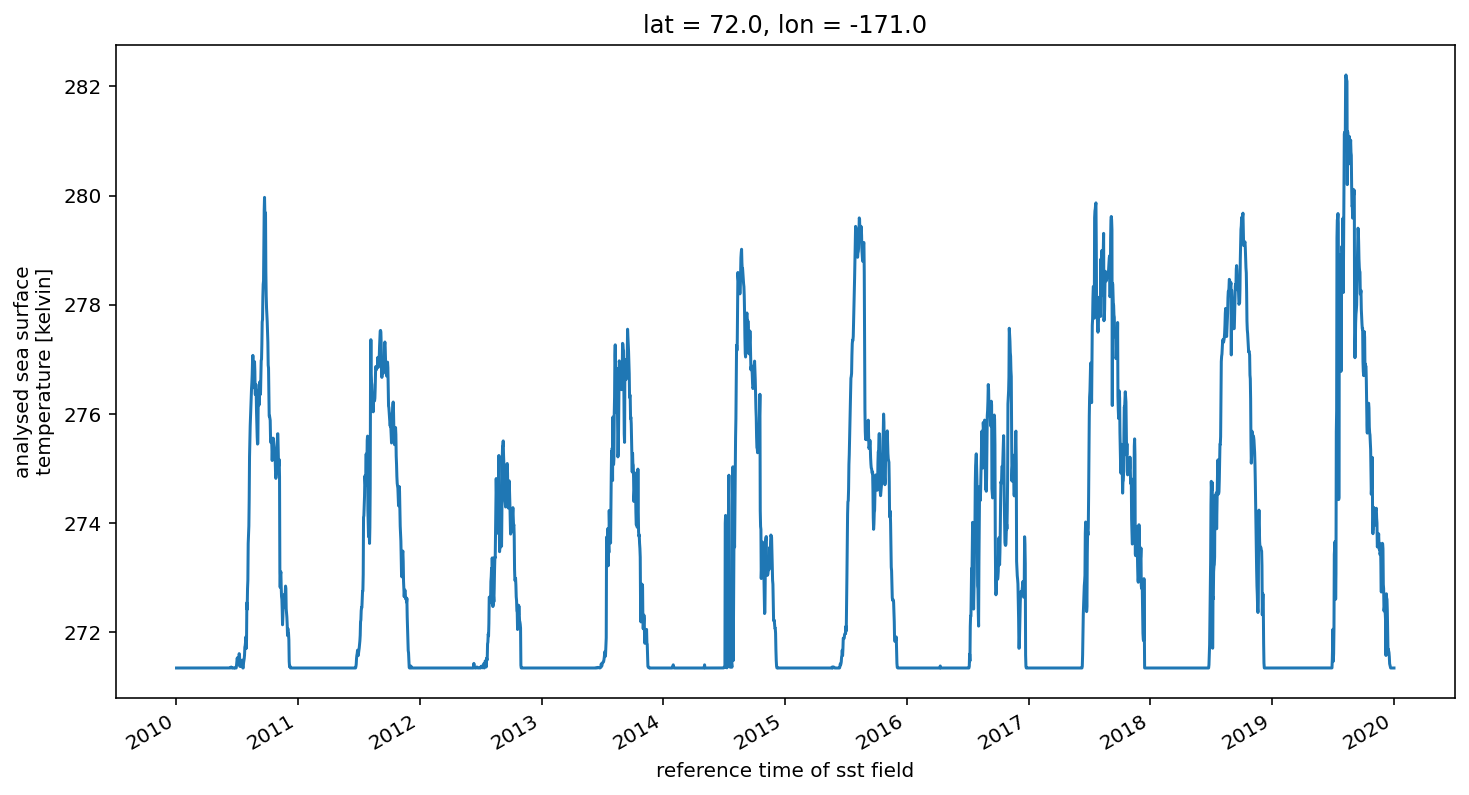

In [5]:
sst_timeseries = ds_sst['analysed_sst'].sel(time = slice('2010-01-01','2020-01-01'),
                                            lat  = 72,
                                            lon  = -171
                                           ).load()

sst_timeseries.plot()

# Grid resolution does NOT equal spatial resolution

- many L4 SST analyses blend infrared (~ 1 - 4 km data) with passive microwave (~ 50 km) data.  Data availability will determine regional / temporal changes in spatial resolution

- many L4 SST analyses apply smoothing filters that may further reduce resolution

CPU times: user 8.33 s, sys: 7.25 s, total: 15.6 s
Wall time: 26.9 s


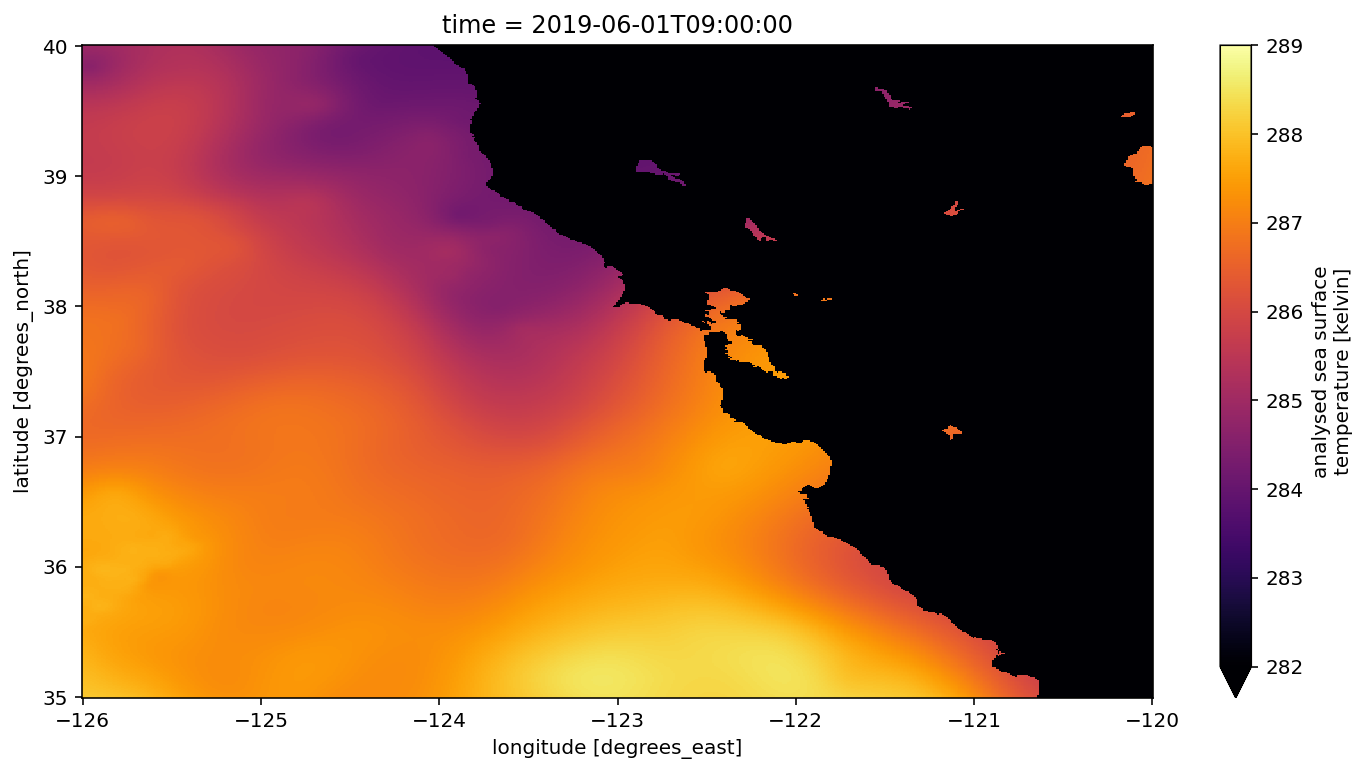

In [6]:
%%time

subset = ds_sst['analysed_sst'].sel(time='2019-06-01',lat=slice(35,40),lon=slice(-126,-120))

subset.plot(vmin=282,vmax=289,cmap='inferno')

CPU times: user 8.32 s, sys: 6.73 s, total: 15 s
Wall time: 16.5 s


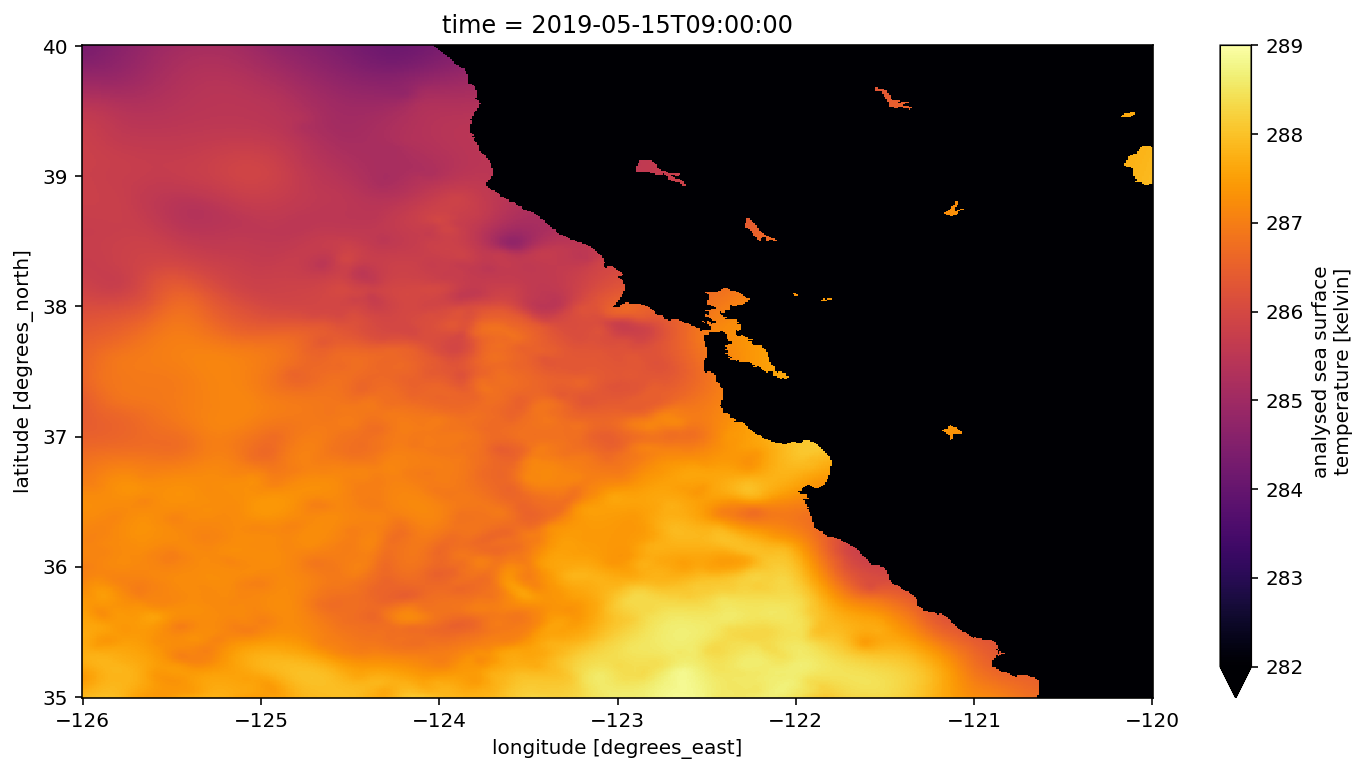

In [7]:
%%time

subset = ds_sst['analysed_sst'].sel(time='2019-05-15',lat=slice(35,40),lon=slice(-126,-120))

subset.plot(vmin=282,vmax=289,cmap='inferno')

# How to find an AWS Public Dataset

- click here: [AWS Public Dataset](https://aws.amazon.com/opendata/)


- Click on `Find public available data on AWS` button
- Search for GOES
- Select [GOES-16 and GOES-17](https://registry.opendata.aws/noaa-goes/)
![](./aws.png)


## NETCDF GEO DATA

## Zarr made it seem so easy to read and access cloud SST data! 
## It is always that easy, right?

- When data is just dumped on the cloud, it is still useful, but can be challenging to use.  
Which brings us to GOES SSTs.....

- Info on the data is here -- GOES has a lot of different parameters and they are all stored in different files with names that are difficult to understand.  There are *80* different data products.  This link lists them all and explains the different directory names. [AWS info on GOES SST data](https://docs.opendata.aws/noaa-goes16/cics-readme.html).  

- The GOES data is netCDF format.  There is a different for each of the 80 projects for year/day/hour.  A lot of files.  I find it really useful to 'browse' s3: buckets so that I can understand the directory and data structure.  [Explore S3 structure](https://noaa-goes16.s3.amazonaws.com/index.html).  The directory structure is `<Product>/<Year>/<Day of Year>/<Hour>/<Filename>`

- In the code below we are going to create a function that searches for all files from a certain day, then creates the keys to opening them.  The files are so messy that opening a day takes a little while.  There are other ways you could write this function depending on what your analysis goals are, this is just one way to get some data in a reasonable amount of time. 
- This function uses 
- [`s3fs.S3FileSystem`](https://s3fs.readthedocs.io/en/latest/) which holds a connection with a s3 bucket and allows you to list files, etc.  
- [`xr.open_mfdataset`](http://xarray.pydata.org/en/stable/generated/xarray.open_mfdataset.html#xarray.open_mfdataset) opens a list of filenames and concatenates the data along the specified dimensions  

Website [https://registry.opendata.aws/noaa-goes/](https://registry.opendata.aws/noaa-goes/)


In [8]:
def get_geo_data(sat,lyr,idyjl):
    # arguments
    # sat   goes-east,goes-west,himawari
    # lyr   year
    # idyjl day of year
    
    d = dt.datetime(lyr,1,1) + dt.timedelta(days=idyjl)
    fs = s3fs.S3FileSystem(anon=True) #connect to s3 bucket!

    #create strings for the year and julian day
    imon,idym=d.month,d.day
    syr,sjdy,smon,sdym = str(lyr).zfill(4),str(idyjl).zfill(3),str(imon).zfill(2),str(idym).zfill(2)
    
    #use glob to list all the files in the directory
    if sat=='goes-east':
        file_location,var = fs.glob('s3://noaa-goes16/ABI-L2-SSTF/'+syr+'/'+sjdy+'/*/*.nc'),'SST'
    if sat=='goes-west':
        file_location,var = fs.glob('s3://noaa-goes17/ABI-L2-SSTF/'+syr+'/'+sjdy+'/*/*.nc'),'SST'
    if sat=='himawari':
        file_location,var = fs.glob('s3://noaa-himawari8/AHI-L2-FLDK-SST/'+syr+'/'+smon+'/'+sdym+'/*/*L2P*.nc'),'sea_surface_temperature'
    
    #make a list of links to the file keys
    if len(file_location)<1:
        return file_ob
    file_ob = [fs.open(file) for file in file_location]        #open connection to files
    
    #open all the day's data
    ds = xr.open_mfdataset(file_ob,combine='nested',concat_dim='time') #note file is super messed up formatting
    
    #clean up coordinates which are a MESS in GOES
    #rename one of the coordinates that doesn't match a dim & should
    if not sat=='himawari':
        ds = ds.rename({'t':'time'})
        ds = ds.reset_coords()
    else:
        ds = ds.rename({'ni':'x','nj':'y'})
    
    #put in to Celsius
    #ds[var] -= 273.15   #nice python shortcut to +- from itself a-=273.15 is the same as a=a-273.15
    #ds[var].attrs['units'] = '$^\circ$C'
   
    return ds


## Open a day of GOES-16  (East Coast) Data

In [ ]:
%%time
lyr, idyjl = 2020, 210  #may 30, 2020

ds = get_geo_data('goes-east',lyr,idyjl)

ds

In [ ]:
%%time
subset = ds.sel(x=slice(-0.01,0.07215601),y=slice(0.12,0.09))  #reduce to GS region

masked = subset.SST.where(subset.DQF==0)

masked.isel(time=14).plot(vmin=14+273.15,vmax=30+273.15,cmap='inferno')

In [ ]:
#%%time

#mean_dy = masked.mean('time',skipna=True)   #here I want all possible values so skipna=True

#mean_dy.plot(vmin=14+273.15,vmax=30+273.15,cmap='inferno')

## Read AWS JMA Himawari SSTs
- define a function to get all the filenames for a day
- AWS info on Himawari SST data, [here](https://www.goes.noaa.gov/f_himawari-8.html)
- Explore S3 structure [here](https://noaa-himawari8.s3.amazonaws.com/index.html)
- SSTs are given in L2P and L3C GHRSST data formats.  
L2P has dims that not mapped to a regular grid.  
L3C is mapped to a grid, with dims lat,lon.

Website [https://registry.opendata.aws/noaa-himawari/](https://registry.opendata.aws/noaa-himawari/)


In [ ]:
%%time
lyr, idyjl = 2020, 212

ds = get_geo_data('himawari',lyr,idyjl)

subset = ds.sel(x=slice(-0.05,0.08),y=slice(0.12,0.08))

masked = subset.sea_surface_temperature.where(subset.quality_level>=4)

mean_dy = masked.mean('time',skipna=True)   #here I want all possible values so skipna=True

mean_dy.plot(vmin=14+273.15,vmax=30+273.15,cmap='inferno')

## ERA5 Data Structure on S3

The ERA5 data is organized into NetCDF files per variable, each containing a month of hourly data. 
The directory structure is `/{year}/{month}/main.nc` for all the variables or `/{year}/{month}/data/{var}.nc` for just a single variable.

Variables:
- snow_density
- sea_surface_temperature
- lwe_thickness_of_surface_snow_amount
- eastward_wind_at_10_metres
- northward_wind_at_10_metres
- time1_bounds
- air_temperature_at_2_metres_1hour_Maximum
- air_temperature_at_2_metres_1hour_Minimum
- precipitation_amount_1hour_Accumulation
- eastward_wind_at_100_metres
- air_temperature_at_2_metres
- dew_point_temperature_at_2_metres
- integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation
- northward_wind_at_100_metres
- air_pressure_at_mean_sea_level
- surface_air_pressure

For example, the full file path for sea surface temperature for January 2008 is:

/2008/01/data/sea_surface_temperature.nc

- Note that due to the nature of the ERA5 forecast timing, which is run twice daily at 06:00 and 18:00 UTC, the monthly data file begins with data from 07:00 on the first of the month and continues through 06:00 of the following month. We'll see this in the coordinate values of a data file we download later in the notebook.

- Granule variable structure and metadata attributes are stored in main.nc. This file contains coordinate and auxiliary variable data. This file is also annotated using NetCDF CF metadata conventions.


In [ ]:
def get_era5(var,lyr):
    syr=str(lyr).zfill(4)
    fs = s3fs.S3FileSystem(anon=True)
    if var=='all':
        file_location = fs.glob('s3://era5-pds/'+syr+'/*/*.nc')
    else:
        file_location = fs.glob('s3://era5-pds/'+syr+'/*/data/'+var+'*.nc')
    file_ob = [fs.open(file) for file in file_location]        
    ds=xr.open_mfdataset(file_ob,combine='nested',concat_dim='time0') 
    #ds['sea_surface_temperature']-=273.15
    #ds['sea_surface_temperature'].attrs['units'] = '$^\circ$C'
    return ds

In [ ]:
%%time

lyr=2019

ds = get_era5('sea_surface_temperature',lyr)

In [ ]:
%%time

dy = ds.resample(time0='1D').mean(keep_attrs=True,skipna=False)

dy

In [ ]:
%%time

dy.sea_surface_temperature[0,:,:].plot()

# Change lon from 0 to 360 to -180 to 180

In [ ]:
%%time

dy.coords['lon'] = (dy.coords['lon'] + 180) % 360 - 180

dy = dy.sortby(dy.lon)

dy.sea_surface_temperature[0,:,:].plot()